In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
from customlib import HelixConn
from customlib import autovis as f
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt 
import geopandas as gpd
from unidecode import unidecode 
from dateutil.relativedelta import relativedelta
import folium
import os
from folium import plugins
import json
from unidecode import unidecode
%matplotlib notebook

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 8})

In [3]:
START_2018 = '14-06-2018 00:00'
END_2018 = '15-06-2018 23:59'

TODAY = dt.datetime.strftime(dt.datetime.now(), "%d-%m-%Y %H:%M")
LAST_3W_START = dt.datetime.strftime(dt.datetime.today()-dt.timedelta(days=21) 
                                     , "%d-%m-%Y") + " 00:00"
YESTERDAY_END = dt.datetime.strftime(dt.datetime.today()-dt.timedelta(days=1)
                                     , "%d-%m-%Y")+" 23:59"

HELIX_CONNECTION_STRING ="TCERDKOC/San/ek1W@helix-scan.turkcell.tgc/HLXUSER"
NECCS_CONNECTION_STRING ="TCERDKOC/cqqb_3xX?959@neccs-scan.turkcell.tgc/neccs"

In [4]:
hlx = HelixConn.HelixConn(HELIX_CONNECTION_STRING)
hlx.connect()

2018-06-25 11:05:03.511962 - C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\customlib\HelixConn.py - conected to db...
2018-06-25 11:05:03.511962 - C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\customlib\HelixConn.py - fetching queries from C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\customlib\queries


Daily drop data of 2016-2017. Run once.. then we read from CSVs.

```python

daily_tr_drop_2017 = hlx.get_custom("drop_daily_global.sql"
                                    , {'SDATE':'01-01-2017 00:00:00'
                                             ,'EDATE':'31-12-2017 23:59:00'}
                                                , "DATETIME")

daily_tr_drop_2016 = hlx.get_custom("drop_daily_global.sql"
                                    , {'SDATE':'01-01-2016 00:00:00'
                                             ,'EDATE':'31-12-2016 23:59:00'}
                                                , "DATETIME")

# we need to extract day of year to be able to overlap years
daily_tr_drop_2016.reset_index(inplace=True)
daily_tr_drop_2017.reset_index(inplace=True)

daily_tr_drop_2016['day_of_year'] = daily_tr_drop_2016.apply(lambda row: row.DATETIME.timetuple().tm_yday, axis=1)
daily_tr_drop_2017['day_of_year'] = daily_tr_drop_2017.apply(lambda row: row.DATETIME.timetuple().tm_yday, axis=1)

daily_tr_drop_2016.set_index("day_of_year", inplace = True)
daily_tr_drop_2017.set_index("day_of_year", inplace = True)

daily_tr_drop_2016['DATETIME_D2'] = daily_tr_drop_2016.apply(lambda row: row.DATETIME 
                                                             + relativedelta(years=2)
                                                             , axis=1)

daily_tr_drop_2017['DATETIME_D2'] = daily_tr_drop_2017.apply(lambda row: row.DATETIME 
                                                             + relativedelta(years=1)
                                                             , axis=1)

daily_tr_drop_2016.to_csv("daily_tr_drop_2016.csv", encoding="utf-8"
                          , date_format = "'%m/%d/%Y %H:%M")
daily_tr_drop_2017.to_csv("daily_tr_drop_2017.csv", encoding="utf-8"
                          , date_format = "'%m/%d/%Y %H:%M")

daily_tr_drop_2018 = pd.read_csv("daily_tr_drop_2018.csv"
                                 ,encoding = "utf-8"
                                 ,parse_dates = ["DATETIME"]
                                 ,index_col="DATETIME") 
```

In [5]:
# read reference data from previous years
daily_tr_drop_2016 = pd.read_csv("daily_tr_drop_2016.csv"
                                 ,encoding = "utf-8"
                                 ,parse_dates = ["DATETIME", "DATETIME_D2"]
                                 ,index_col="DATETIME_D2") 

daily_tr_drop_2017 = pd.read_csv("daily_tr_drop_2017.csv"
                                 ,encoding = "utf-8"
                                 ,parse_dates = ["DATETIME", "DATETIME_D2"]
                                 ,index_col="DATETIME_D2") 

daily_tr_drop_2018 = pd.read_csv("daily_tr_drop_2018.csv"
                                 ,encoding = "utf-8"
                                 ,parse_dates = ["DATETIME"]
                                 ,index_col="DATETIME")

In [6]:
daily_tr_drop_2018 = hlx.get_custom("drop_daily_global.sql"
                                    ,{'SDATE':START_2018,'EDATE':END_2018}
                                    ,"DATETIME")

2018-06-25 11:05:26.993864 - HelixConn - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\customlib\queries\drop_daily_global.sql


In [7]:
daily_tr_drop_2018.to_csv("daily_tr_drop_2018.csv", encoding="utf-8"
                          , date_format = "'%m/%d/%Y %H:%M")

In [8]:
daily_tr_drop_2018.head()

HIER_ELEMENT  COUNT_CELL  TRAFF_2G  TRAFF_3G  TOTAL_DROP_2G  \
DATETIME                                                                 
2018-06-14     TURKCELL      334420   1866654   7071506         499123   
2018-06-15     TURKCELL      334412   3143366   8770448         869448   

            TOTAL_2G_CS_CALLS  DROP_PERC_2G  TOTAL_DROP_3G  TOTAL_3G_CS_CALLS  \
DATETIME                                                                        
2018-06-14           79441581          0.63         856823          328089999   
2018-06-15          108979743          0.80        1237970          361342618   

            DROP_PERC_3G  
DATETIME                  
2018-06-14          0.26  
2018-06-15          0.34

In [9]:

# calculate time converisons for spreading, nth day, week, month of year
daily_tr_drop_2018.reset_index(inplace=True)
daily_tr_drop_2018['d'] = daily_tr_drop_2018.apply(lambda row: row.DATETIME.timetuple().tm_yday, axis=1)
daily_tr_drop_2018['w'] = daily_tr_drop_2018.apply(lambda row: row.DATETIME.isocalendar()[1], axis=1)
daily_tr_drop_2018['m'] = daily_tr_drop_2018.apply(lambda row: row.DATETIME.month, axis=1)
daily_tr_drop_2018.set_index("DATETIME", inplace=True)

# ratio of calls wrt RAT
daily_tr_drop_2018['ratio_2G_to_3G'] = \
    100*daily_tr_drop_2018.TOTAL_DROP_2G/(daily_tr_drop_2018.TOTAL_DROP_2G + daily_tr_drop_2018.TOTAL_DROP_3G)
daily_tr_drop_2018['ratio_3G_to_2G'] = 100 - daily_tr_drop_2018['ratio_2G_to_3G']

w = daily_tr_drop_2018.groupby('w')[ 'TOTAL_DROP_2G', 'TOTAL_2G_CS_CALLS'
    , 'TOTAL_DROP_3G', 'TOTAL_3G_CS_CALLS', 'TRAFF_2G', 'TRAFF_3G'].sum()
# group over month
m = daily_tr_drop_2018.groupby('m')['TOTAL_DROP_2G', 'TOTAL_2G_CS_CALLS'
    , 'TOTAL_DROP_3G', 'TOTAL_3G_CS_CALLS', 'TRAFF_2G', 'TRAFF_3G'].sum()

# drop rates must ve valcılated from sigma drop/sigma attempt
w['DROP_PERC_2G'] = w.TOTAL_DROP_2G/w.TOTAL_2G_CS_CALLS * 100
w['DROP_PERC_3G'] = w.TOTAL_DROP_3G/w.TOTAL_3G_CS_CALLS * 100
m['DROP_PERC_2G'] = m.TOTAL_DROP_2G/m.TOTAL_2G_CS_CALLS * 100
m['DROP_PERC_3G'] = m.TOTAL_DROP_3G/m.TOTAL_3G_CS_CALLS * 100

In [10]:
daily_tr_drop_2018.sort_index(inplace=True)

<IPython.core.display.Javascript object>


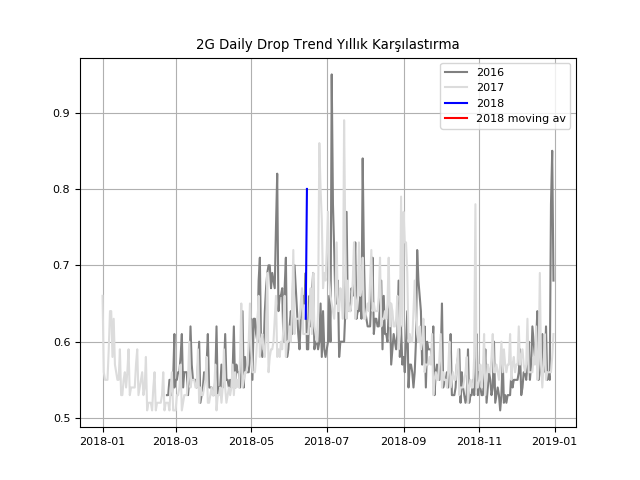

In [11]:
ax = plt.figure() 
plt.plot(daily_tr_drop_2016.DROP_PERC_2G, color="gray", label="2016")
plt.plot(daily_tr_drop_2017.DROP_PERC_2G, color="gainsboro", label="2017")
plt.plot(daily_tr_drop_2018.DROP_PERC_2G, color="blue", label="2018" )
plt.plot(daily_tr_drop_2018.DROP_PERC_2G.rolling(window=7).mean(), color="red", label="2018 moving av")
plt.legend()
plt.title("2G Daily Drop Trend Yıllık Karşılastırma")
plt.grid()

<IPython.core.display.Javascript object>


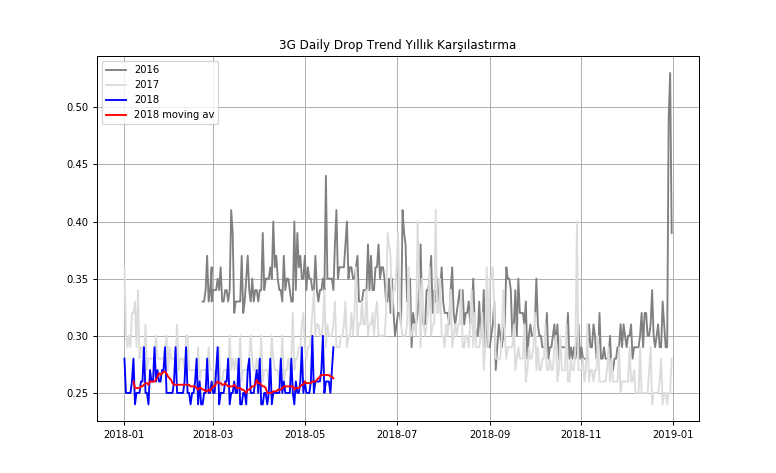

In [14]:
ax = plt.figure() 
plt.plot(daily_tr_drop_2016.DROP_PERC_3G, color="gray", label="2016")
plt.plot(daily_tr_drop_2017.DROP_PERC_3G, color="gainsboro", label="2017")
plt.plot(daily_tr_drop_2018.DROP_PERC_3G, color="blue", label="2018")
plt.plot(daily_tr_drop_2018.DROP_PERC_3G.rolling(window=7).mean(), color="red", label="2018 moving av")
plt.legend()
plt.title("3G Daily Drop Trend Yıllık Karşılastırma")
plt.grid()

<IPython.core.display.Javascript object>


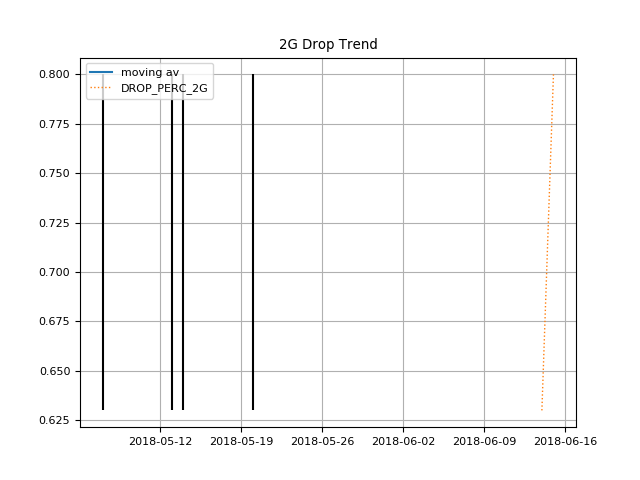

In [12]:
ax = plt.figure() 
plt.plot(daily_tr_drop_2018.DROP_PERC_2G.rolling(window=7).mean(),  label = "moving av")
plt.plot(daily_tr_drop_2018.DROP_PERC_2G,  ls=":", lw=1)
plt.vlines([dt.datetime(2018,5,7), dt.datetime(2018,5,13)
            , dt.datetime(2018,5,14), dt.datetime(2018,5,20)]
           , daily_tr_drop_2018.DROP_PERC_2G.min()
           , daily_tr_drop_2018.DROP_PERC_2G.max())
plt.legend()
plt.title("2G Drop Trend")
plt.grid()

In [19]:
daily_tr_drop_2018.head()

HIER_ELEMENT  COUNT_CELL  TRAFF_2G  TRAFF_3G  TOTAL_DROP_2G  \
DATETIME                                                                 
2018-01-01     TURKCELL      316207   2048029   6176804         403844   
2018-01-02     TURKCELL      316464   2252201   8188804         444330   
2018-01-03     TURKCELL      316741   2246992   8149026         443389   
2018-01-04     TURKCELL      316897   2233618   8173246         441921   
2018-01-05     TURKCELL      316563   2284300   8244152         458645   

            TOTAL_2G_CS_CALLS  DROP_PERC_2G  TOTAL_DROP_3G  TOTAL_3G_CS_CALLS  \
DATETIME                                                                        
2018-01-01           69477334          0.58         649065          235494111   
2018-01-02           81036312          0.55         786353          319742655   
2018-01-03           79711841          0.56         781715          314120613   
2018-01-04           78969884          0.56         778595          314046557   
2018-01-05           82137367          0.56         809112          328478572   

            DROP_PERC_3G  d  w  m  ratio_2G_to_3G  ratio_3G_to_2G  
DATETIME                                                           
2018-01-01          0.28  1  1  1       38.355072       61.644928  
2018-01-02          0.25  2  1  1       36.104342       63.895658  
2018-01-03          0.25  3  1  1       36.191948       63.808052  
2018-01-04          0.25  4  1  1       36.207719       63.792281  
2018-01-05          0.25  5  1  1       36.177674       63.822326

In [13]:
drop_before=hlx.get_hier_dtim(query="drop_daily.sql",elm="%%",lev="COUNTY"
                           ,sdate='14-06-2018 00:00:00'
                          ,edate='15-06-2018 23:59:00')

drop_after=hlx.get_hier_dtim(query="drop_daily.sql",elm="%%",lev="COUNTY"
                           ,sdate='21-06-2018 00:00:00'
                          ,edate='22-06-2018 23:59:00')

2018-06-25 11:06:46.113523 - HelixConn - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\customlib\queries\drop_daily.sql
2018-06-25 11:06:54.988194 - HelixConn - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\customlib\queries\drop_daily.sql


In [14]:
drop_after.head()

HIER_LEVEL  COUNT_CELL        LAT        LON  \
HIER_ELEMENT         DATETIME                                                  
Eskişehir-Odunpazarı 2018-06-22     COUNTY        1089  39.755494  30.547287   
Çanakkale-Ezine      2018-06-21     COUNTY         227  39.789100  26.257775   
Bilecik-Gölpazarı    2018-06-22     COUNTY          60  40.262733  30.352577   
Kocaeli-Dilovası     2018-06-21     COUNTY         410  40.802762  29.548468   
Hatay-Erzin          2018-06-22     COUNTY         114  36.940185  36.158993   

                                 TRAFF_2G  TRAFF_3G  TOTAL_DROP_2G  \
HIER_ELEMENT         DATETIME                                        
Eskişehir-Odunpazarı 2018-06-22    7135.0     37082         1068.0   
Çanakkale-Ezine      2018-06-21     506.0      2256          155.0   
Bilecik-Gölpazarı    2018-06-22     352.0       701          120.0   
Kocaeli-Dilovası     2018-06-21    1974.0     10794          786.0   
Hatay-Erzin          2018-06-22     685.0      2634          204.0   

                                 TOTAL_2G_CS_CALLS  DROP_PERC_2G  \
HIER_ELEMENT         DATETIME                                      
Eskişehir-Odunpazarı 2018-06-22           280202.0          0.38   
Çanakkale-Ezine      2018-06-21            19151.0          0.81   
Bilecik-Gölpazarı    2018-06-22            12919.0          0.93   
Kocaeli-Dilovası     2018-06-21            74820.0          1.05   
Hatay-Erzin          2018-06-22            27942.0          0.73   

                                 TOTAL_DROP_3G  TOTAL_3G_CS_CALLS  \
HIER_ELEMENT         DATETIME                                       
Eskişehir-Odunpazarı 2018-06-22           2758            1541518   
Çanakkale-Ezine      2018-06-21            240              90245   
Bilecik-Gölpazarı    2018-06-22            146              29196   
Kocaeli-Dilovası     2018-06-21           1322             446534   
Hatay-Erzin          2018-06-22            331             107399   

                                 DROP_PERC_3G  
HIER_ELEMENT         DATETIME                  
Eskişehir-Odunpazarı 2018-06-22          0.18  
Çanakkale-Ezine      2018-06-21          0.27  
Bilecik-Gölpazarı    2018-06-22          0.50  
Kocaeli-Dilovası     2018-06-21          0.30  
Hatay-Erzin          2018-06-22          0.31

In [15]:
before = drop_before.groupby('HIER_ELEMENT')[ 'TOTAL_DROP_2G', 'TOTAL_2G_CS_CALLS'
        , 'TOTAL_DROP_3G', 'TOTAL_3G_CS_CALLS', 'TRAFF_2G', 'TRAFF_3G'].sum()

after = drop_after.groupby('HIER_ELEMENT')[ 'TOTAL_DROP_2G', 'TOTAL_2G_CS_CALLS'
        , 'TOTAL_DROP_3G', 'TOTAL_3G_CS_CALLS', 'TRAFF_2G', 'TRAFF_3G'].sum()

drop_before['DROP_PERC_2G'] = drop_before.TOTAL_DROP_2G/drop_before.TOTAL_2G_CS_CALLS * 100
drop_before['DROP_PERC_3G'] = drop_before.TOTAL_DROP_3G/drop_before.TOTAL_3G_CS_CALLS * 100

drop_after['DROP_PERC_2G'] = drop_after.TOTAL_DROP_2G/drop_after.TOTAL_2G_CS_CALLS * 100
drop_after['DROP_PERC_3G'] = drop_after.TOTAL_DROP_3G/drop_after.TOTAL_3G_CS_CALLS * 100

In [16]:
before.fillna(0, inplace=True)
after.fillna(0, inplace=True)

In [17]:
before["2g_drop_contr"] = 100*before.TOTAL_DROP_2G/sum(before.TOTAL_DROP_2G)
before["3g_drop_contr"] = 100*before.TOTAL_DROP_3G/sum(before.TOTAL_DROP_3G)
after["2g_drop_contr"] = 100*after.TOTAL_DROP_2G/sum(after.TOTAL_DROP_2G)
after["3g_drop_contr"] = 100*after.TOTAL_DROP_3G/sum(after.TOTAL_DROP_3G)

In [18]:
before.head()

TOTAL_DROP_2G  TOTAL_2G_CS_CALLS  TOTAL_DROP_3G  \
HIER_ELEMENT                                                       
Adana-Aladağ            1475.0            97195.0           1528   
Adana-Ceyhan            4209.0           404000.0           3777   
Adana-Feke              1607.0           124759.0           1486   
Adana-Karaisalı         1948.0           153128.0           1682   
Adana-Karataş           1200.0           138542.0            893   

                 TOTAL_3G_CS_CALLS  TRAFF_2G  TRAFF_3G  2g_drop_contr  \
HIER_ELEMENT                                                            
Adana-Aladağ                212731    2373.0      4527       0.107801   
Adana-Ceyhan                931651   10058.0     20867       0.307615   
Adana-Feke                  159738    3594.0      3974       0.117448   
Adana-Karaisalı             240299    3923.0      5416       0.142370   
Adana-Karataş               394233    3441.0      8768       0.087702   

                 3g_drop_contr  
HIER_ELEMENT                    
Adana-Aladağ          0.072990  
Adana-Ceyhan          0.180421  
Adana-Feke            0.070984  
Adana-Karaisalı       0.080346  
Adana-Karataş         0.042657

<IPython.core.display.Javascript object>


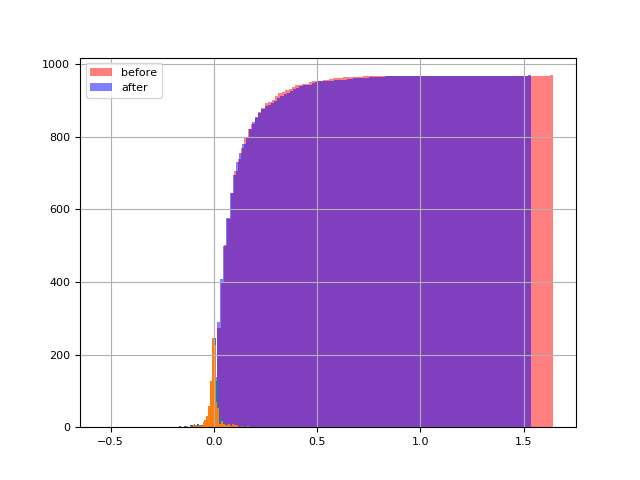

In [19]:
ax = plt.figure() 
plt.hist(before["2g_drop_contr"], cumulative=True, bins=100, color="red", label="before", alpha=0.5)
plt.hist(after["2g_drop_contr"], cumulative=True, bins=100, color="blue", label="after", alpha=0.5)
plt.legend()
plt.grid()

In [22]:
tr_county = os.path.join('data', 't4.json')
geo_json_data = json.load(open(tr_county, encoding="utf8"))
m = folium.Map([43, -100], zoom_start=4)
folium.GeoJson(geo_json_data).add_to(m)

In [23]:
before.reset_index(inplace=True)
after.reset_index(inplace=True)

before['COUNTY'] = before.apply(lambda row: unidecode(row.HIER_ELEMENT.split("-")[1].upper())
                                      , axis=1)
after['COUNTY'] = after.apply(lambda row: unidecode(row.HIER_ELEMENT.split("-")[1].upper())
                                      , axis=1)

In [24]:
m = folium.Map([43, 30], zoom_start=6)

m.choropleth(
    geo_data=geo_json_data,
    data=before,
    columns=['COUNTY', '2g_drop_contr'],
    key_on='feature.properties.NAME_EN',
    fill_color='YlOrRd',
    line_color='black', line_weight=0,
    fill_opacity=0.8,
    threshold_scale=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
)
m

In [25]:
m = folium.Map([43, 30], zoom_start=6)

m.choropleth(
    geo_data=geo_json_data,
    data=after,
    columns=['COUNTY', '2g_drop_contr'],
    key_on='feature.properties.NAME_EN',
    fill_color='YlOrRd',
    line_color='black', line_weight=0,
    fill_opacity=0.8,
    threshold_scale=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
)
m

In [26]:
before.set_index("COUNTY", inplace=True)
after.set_index("COUNTY", inplace=True)
after.head()

index     HIER_ELEMENT  TOTAL_DROP_2G  TOTAL_2G_CS_CALLS  \
COUNTY                                                                
ALADAG         0     Adana-Aladağ         1035.0            67853.0   
CEYHAN         1     Adana-Ceyhan         2824.0           315714.0   
FEKE           2       Adana-Feke          884.0            79687.0   
KARAISALI      3  Adana-Karaisalı         1034.0           101311.0   
KARATAS        4    Adana-Karataş          989.0           133859.0   

           TOTAL_DROP_3G  TOTAL_3G_CS_CALLS  TRAFF_2G  TRAFF_3G  \
COUNTY                                                            
ALADAG              1187             138385    1955.0      3458   
CEYHAN              2586             863860    8243.0     21150   
FEKE                 788             100523    2478.0      2789   
KARAISALI            835             171711    3111.0      4434   
KARATAS              708             402368    3307.0      9262   

           2g_drop_contr  3g_drop_contr  
COUNTY                                   
ALADAG          0.092426       0.060456  
CEYHAN          0.252183       0.131710  
FEKE            0.078941       0.040135  
KARAISALI       0.092336       0.042528  
KARATAS         0.088318       0.036060

In [27]:
before.head()

index     HIER_ELEMENT  TOTAL_DROP_2G  TOTAL_2G_CS_CALLS  \
COUNTY                                                                
ALADAG         0     Adana-Aladağ         1475.0            97195.0   
CEYHAN         1     Adana-Ceyhan         4209.0           404000.0   
FEKE           2       Adana-Feke         1607.0           124759.0   
KARAISALI      3  Adana-Karaisalı         1948.0           153128.0   
KARATAS        4    Adana-Karataş         1200.0           138542.0   

           TOTAL_DROP_3G  TOTAL_3G_CS_CALLS  TRAFF_2G  TRAFF_3G  \
COUNTY                                                            
ALADAG              1528             212731    2373.0      4527   
CEYHAN              3777             931651   10058.0     20867   
FEKE                1486             159738    3594.0      3974   
KARAISALI           1682             240299    3923.0      5416   
KARATAS              893             394233    3441.0      8768   

           2g_drop_contr  3g_drop_contr  
COUNTY                                   
ALADAG          0.107801       0.072990  
CEYHAN          0.307615       0.180421  
FEKE            0.117448       0.070984  
KARAISALI       0.142370       0.080346  
KARATAS         0.087702       0.042657

In [30]:
temp = after["2g_drop_contr"]-before["2g_drop_contr"]
delta = temp.to_frame()
delta["2g_drop_contr"].hist(bins=100)
delta.reset_index(inplace=True)

In [31]:
m = folium.Map([43, 30], zoom_start=6)

m.choropleth(
    geo_data=geo_json_data,
    data=delta,
    columns=['COUNTY', '2g_drop_contr'],
    key_on='feature.properties.NAME_EN',
    fill_color='RdYlGn',
    line_color='black', line_weight=0,
    fill_opacity=0.8,
    threshold_scale=[-0.03, -0.01,  0, 0.01, 0.03]
)
m

In [32]:
daily_tr_drop_2018.head()

HIER_ELEMENT  COUNT_CELL  TRAFF_2G  TRAFF_3G  TOTAL_DROP_2G  \
DATETIME                                                                 
2018-06-14     TURKCELL      334420   1866654   7071506         499123   
2018-06-15     TURKCELL      334412   3143366   8770448         869448   

            TOTAL_2G_CS_CALLS  DROP_PERC_2G  TOTAL_DROP_3G  TOTAL_3G_CS_CALLS  \
DATETIME                                                                        
2018-06-14           79441581          0.63         856823          328089999   
2018-06-15          108979743          0.80        1237970          361342618   

            DROP_PERC_3G    d   w  m  ratio_2G_to_3G  ratio_3G_to_2G  
DATETIME                                                              
2018-06-14          0.26  165  24  6       36.809947       63.190053  
2018-06-15          0.34  166  24  6       41.256552       58.743448

In [33]:
mersin=hlx.get_hier_dtim(query="drop_daily.sql",elm="%Mersin%",lev="COUNTY"
                           ,sdate='01-05-2018 00:00:00'
                          ,edate='20-05-2018 23:59:00')


2018-06-25 11:10:32.414556 - HelixConn - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\customlib\queries\drop_daily.sql


In [40]:
adana=hlx.get_hier_dtim(query="drop_daily.sql",elm="%Adana%",lev="COUNTY"
                           ,sdate='01-05-2018 00:00:00'
                          ,edate='20-05-2018 23:59:00')

2018-05-21 15:21:30.695996 - HelixConn - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\customlib\queries\drop_daily.sql


<IPython.core.display.Javascript object>


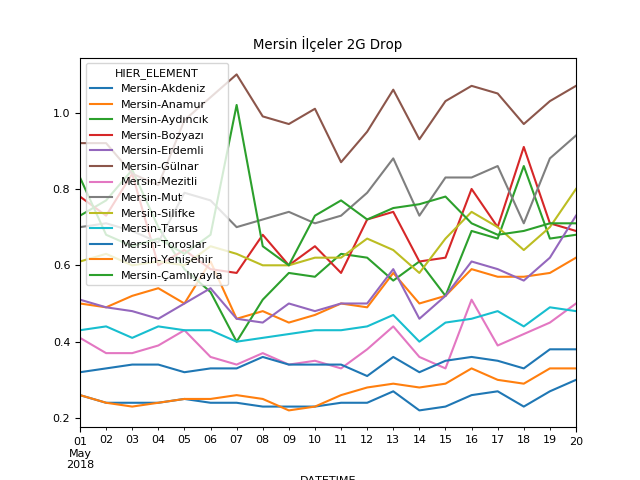

In [34]:
mersin.unstack("HIER_ELEMENT")["DROP_PERC_2G"].plot(title="Mersin İlçeler 2G Drop")

<IPython.core.display.Javascript object>


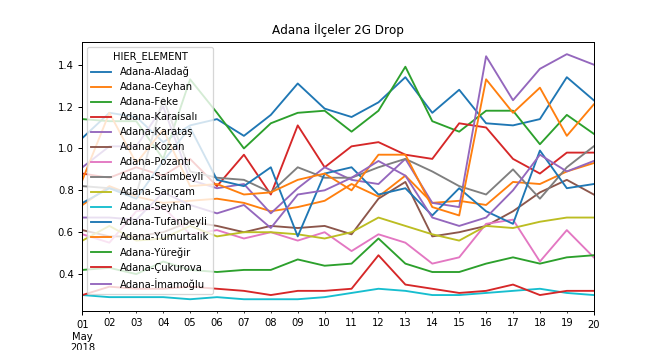

In [47]:
adana.unstack("HIER_ELEMENT")["DROP_PERC_2G"].plot(title="Adana İlçeler 2G Drop")

In [ ]:
temp = -apr_end.DROP_PERC_2G+mar_start.DROP_PERC_2G
delta2 = temp.to_frame()
delta2["DROP_PERC_2G"].hist(bins=100)
delta2.reset_index(inplace=True)

In [ ]:
m = folium.Map([43, 30], zoom_start=6)

m.choropleth(
    geo_data=geo_json_data,
    data=delta2,
    columns=['COUNTY', 'DROP_PERC_2G'],
    key_on='feature.properties.NAME_EN',
    fill_color='RdYlGn',
    line_color='black', line_weight=0,
    fill_opacity=0.8,
    threshold_scale=[ -0.3, -0.1, 0, 0.1, 0.3]
)
m

In [ ]:
last_3_weeks = hlx.get_custom("drop_hourly_global.sql"
                                    , {'SDATE':LAST_3W_START, 'EDATE': YESTERDAY_END}, "DATETIME")

In [ ]:
last_3_weeks.to_csv("last_3_weeks.csv", encoding="utf-8", date_format = "'%m/%d/%Y %H:%M")

In [ ]:
last_3_weeks = pd.read_csv("last_3_weeks.csv"
                                 ,encoding = "utf-8"
                                 ,parse_dates = ["DATETIME"]
                                 ,index_col="DATETIME") 

In [ ]:
f.drop_weekly_dashboard(df=last_3_weeks)

In [ ]:
last_3_weeks.head()

In [ ]:
drop_mar_apr=hlx.get_hier_dtim(query="drop_daily.sql",elm="%%",lev="COUNTY"
                           ,sdate='01-03-2018 00:00:00'
                          ,edate='30-04-2018 23:59:00')

In [ ]:
drop_mar_apr.head()

In [ ]:
drop_apr.reset_index(inplace=True)
drop_apr['day_of_year'] = drop_apr.apply(lambda row: row.DATETIME.timetuple().tm_yday, axis=1)
drop_apr['week_of_year'] = drop_apr.apply(lambda row: row.DATETIME.isocalendar()[1], axis=1)
drop_apr['month_of_year'] = drop_apr.apply(lambda row: row.DATETIME.month, axis=1)

In [ ]:
drop_mar.reset_index(inplace=True)
drop_mar['day_of_year'] = drop_mar.apply(lambda row: row.DATETIME.timetuple().tm_yday, axis=1)
drop_mar['week_of_year'] = drop_mar.apply(lambda row: row.DATETIME.isocalendar()[1], axis=1)
drop_mar['month_of_year'] = drop_mar.apply(lambda row: row.DATETIME.month, axis=1)

In [ ]:
drop_apr.fillna(0, inplace=True)
drop_mar.fillna(0, inplace=True)

In [ ]:
drop_mar_agr = drop_mar.groupby(["HIER_ELEMENT" ]).sum()
drop_apr_agr = drop_apr.groupby(["HIER_ELEMENT" ]).sum()

In [ ]:
drop_mar_agr["2g_drop_contr"] = 100*drop_mar_agr.TOTAL_DROP_2G/sum(drop_mar_agr.TOTAL_DROP_2G)
drop_apr_agr["2g_drop_contr"] = 100*drop_apr_agr.TOTAL_DROP_2G/sum(drop_apr_agr.TOTAL_DROP_2G)
drop_mar_agr["3g_drop_contr"] = 100*drop_mar_agr.TOTAL_DROP_3G/sum(drop_mar_agr.TOTAL_DROP_3G)
drop_apr_agr["3g_drop_contr"] = 100*drop_apr_agr.TOTAL_DROP_3G/sum(drop_apr_agr.TOTAL_DROP_3G)

In [ ]:
drop_mar_agr.head()

In [ ]:
tr_county = os.path.join('data', 't4.json')
geo_json_data = json.load(open(tr_county, encoding="utf8"))
m = folium.Map([43, -100], zoom_start=4)
folium.GeoJson(geo_json_data).add_to(m)

In [ ]:
drop_apr_agr.reset_index(inplace=True)
drop_mar_agr.reset_index(inplace=True)
drop_apr_agr['COUNTY'] = drop_apr_agr.apply(lambda row: row.HIER_ELEMENT.split("-")[1].upper(), axis=1)
drop_mar_agr['COUNTY'] = drop_mar_agr.apply(lambda row: row.HIER_ELEMENT.split("-")[1].upper(), axis=1)

In [ ]:
df = drop_apr_agr.copy()

In [ ]:
drop_apr_agr.head()

In [ ]:
m = folium.Map([43, 30], zoom_start=6)

m.choropleth(
    geo_data=geo_json_data,
    data=drop_apr_agr,
    columns=['temp', '2g_drop_contr'],
    key_on='feature.properties.NAME_EN',
    fill_color='YlOrRd',
    line_color='black', line_weight=0,
    fill_opacity=0.8,
    threshold_scale=[0, 0.1, 0.2, 0.3, 0.4, 0.5]
)

m

In [ ]:
m.save(os.path.join('nisandrop.html'))

In [ ]:
z = poly.join(county_h, how = "right")
z["dummy"] = 10
z.dummy[z.geometry.isna()] = 0
st = 'TOTAL_3G_CS_CALLS'
ax = z.plot(st, cmap ="RdYlGn_r", legend = True)
ax.set_title(st)

In [ ]:
z[z.geometry.isna()==True]

In [ ]:
county_h.key[county_h.key.duplicated()]

In [ ]:
dr_jan.to_csv("data.csv", encoding="utf-8", date_format = "'%m/%d/%Y %H:%M")

In [ ]:
df = pd.read_csv("data.csv", encoding = "utf-8", parse_dates = ["DATETIME", "DDATE"] )

In [ ]:
dr_delta = hlx.get_hier_dtim("drop_hourly.sql", str(dr_master.DATETIME.max() + timedelta(minutes=30))
                             , datetime.now().strftime("%Y %m %d %H:%M:%S"), "COUNTY", "%%")

In [ ]:
dr_delta.reset_index(inplace=True)

In [ ]:
a = pd.concat([dr_master, dr_delta])

In [ ]:
a.DATETIME.max()

In [ ]:
country_h = df.groupby(['DATETIME'])['TOTAL_DROP_2G'
                                         , 'TOTAL_2G_CS_CALLS', 'TOTAL_DROP_3G'
                                         , 'TOTAL_3G_CS_CALLS', 'TRAFF_2G'
                                         , 'TRAFF_3G'].sum()
country_h['2G Drop %'] = country_daily['TOTAL_DROP_2G'] / country_daily['TOTAL_2G_CS_CALLS'] *100
country_h['3G Drop %'] = country_daily['TOTAL_DROP_3G'] / country_daily['TOTAL_3G_CS_CALLS'] *100

In [ ]:
country_d = df.groupby(['DDATE'])['TOTAL_DROP_2G'
                                         , 'TOTAL_2G_CS_CALLS', 'TOTAL_DROP_3G'
                                         , 'TOTAL_3G_CS_CALLS', 'TRAFF_2G'
                                         , 'TRAFF_3G'].sum()
country_d['2G Drop %'] = country_daily['TOTAL_DROP_2G'] / country_daily['TOTAL_2G_CS_CALLS'] *100
country_d['3G Drop %'] = country_daily['TOTAL_DROP_3G'] / country_daily['TOTAL_3G_CS_CALLS'] *100

In [ ]:
plt.figure()
ax = country_h[['2G Drop %', '3G Drop %']].plot()
country_d[['2G Drop %', '3G Drop %']].plot(ax=ax)

In [ ]:
plt.figure()
ax1 = country_h[['TOTAL_DROP_2G', 'TOTAL_DROP_3G']].plot()
country_d[['TOTAL_DROP_2G', 'TOTAL_DROP_3G']].plot(ax=ax1)

In [ ]:
from dbfpy import dbf


In [ ]:

db = dbf.Dbf(".\\TUR_adm_shp\\TUR_adm2.dbf")

In [ ]:
def countykey(s):
    a=s.split('-')
    return "TR."+unidecode(a[0][:2]).upper()+"."+unidecode(a[1][:2]).upper()


In [ ]:
dr_jan["key"] = dr_jan.apply(lambda row: countykey(row["city_county"]), axis=1)

In [ ]:
dr_jan.head()

In [ ]:
z.to_csv("z2.csv")
#county_h.to_csv("c.csv")

In [ ]:
print(p)